##### HW7 Topic Modeling #####
### Performing E/M algorithm: iteration 0
   E-step
   M-Step
   Detected change of 104.33239830447722
### Performing E/M algorithm: iteration 1
   E-step
   M-Step
   Detected change of 0.46894132158417345
### Performing E/M algorithm: iteration 2
   E-step
   M-Step
   Detected change of 0.046487649914594795
### Performing E/M algorithm: iteration 3
   E-step
   M-Step
   Detected change of 0.004410369132571547
### Performing E/M algorithm: iteration 4
   E-step
   M-Step
   Detected change of 0.000420887245486301
indexes : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
weights : [[0.03388343 0.03337129 0.0328403  0.03255031 0.03363359 0.03378485
  0.03264687 0.03281759 0.03207651 0.03478067 0.03348952 0.03340014
  0.03364628 0.03329315 0.03213924 0.03321326 0.03339781 0.03319467
  0.0324004  0.03315844 0.033262   0.03396784 0.03483843 0.03347434
  0.03406624 0.0330397  0.03299515 0.0344191

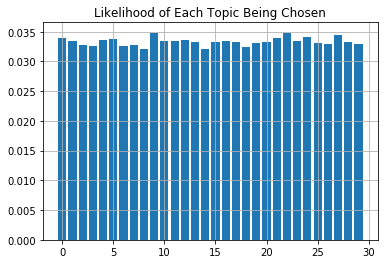

In [265]:
import pandas as pd
import numpy as np
from random import *
#from scipy.stats import multinomial
import matplotlib.pyplot as plt
np.random.seed(101)

k=30

def load_vocab():
    file = "/Users/shairozsohail/Downloads/nips_words.txt"
    print("   Loading vocab from file: {}".format(file))
    data = pd.read_csv(file,delimiter='\n')
    return data

def load_data():
    nips = pd.read_csv('/Users/shairozsohail/Downloads/nips.txt',delimiter=' ')
    nips = nips.pivot(columns='wordid', index='docid', values='count')
    nips = nips.fillna(value=0)
    nips = np.add(nips,0.1)
    
    # Filtering for words that appear too infrequently to contribute to topics
    infreq_words = list(np.flatnonzero((np.sum(nips.values, 1)<50)))
    allcols = list(range(1,nips.values.shape[0]))
    cols = [x for x in allcols if x not in infreq_words]
    nips = nips.iloc[:,cols]
    nips.columns = list(range(0,nips.shape[1]))
    #nips = nips.add(1)
    nips_data = nips.values

    # print(str(nips.shape[0]) + " unique documents")
    # print(str(nips.shape[1]) + " unique words")
    nips.head()
    return nips

def show_histogram(weights,title='Likelihood of Each Topic Being Chosen'):
    plt.figure(1)
    
    indexes = list(range(0,weights.shape[1]))
    print("indexes : {}".format(indexes))
    print("weights : {}".format(weights))
    plt.bar(indexes, weights[0], label=indexes)
     
    plt.xscale('linear')
    plt.yscale('linear')
        
    plt.title(title)
    # plt.legend()
    plt.grid(True)
    plt.show()
    pass

def show_table(word_probs):
    #TODO display table
    pass

def doc_word_freq(docid,wordid,data):
    return(data[wordid][docid])

def topic_word_freq(topicid,wordid,topics):
    return(topics[topicid,wordid]) 

def doc_likelihood(docid, topic, data):
    # P(d | weights)
    words = list(range(0,data.shape[0]))
    adw = [np.round(doc_word_freq(docid,wordid,data)) for wordid in words]
    likelihood = 1
    for word in range(data.shape[0]):
        likelihood *= (topic)**(adw[word-1])
    return(likelihood)

def e_step(data,mu,k,pi):
    
    # data is a dxn numpy array of word counts
    # mu is a kxd numpy array of cluster centroids
    # k is the cluster number
    # pi is a kx1 array of cluster membership probabilities
    
    n = data.shape[0]
    d = data.shape[1]

    h1 = np.multiply(data,data)
    h1 = np.matmul(h1,np.ones((d,k)))
    h2 = np.matmul(np.ones((n,d)), np.multiply(mu,mu).T)
    h3 = np.matmul(data,mu.T)
    H = -0.5*(np.subtract(np.add(h1,h2),2*h3))

    P = np.matmul(np.ones((n,1)),pi.T)
    E = np.multiply(np.exp(H),P)
    F = np.matmul(E,np.ones((k,k)))
    F = np.add(F,1)
    W = np.divide(E,F)

    return(W)

def m_step_log(W,data,pis,alpha):
    n = data.shape[0]
    d = data.shape[1]
    pi_new = np.log(np.matmul(W.T,np.ones((n,1))))
    pi_new = np.subtract(pi_new, np.log(n))
    W = np.multiply(alpha,W)
    mu_new = np.matmul(W.T,data)
    mu_new = np.divide(mu_new,np.matmul(W.T,np.ones((n,d))))
    pi_new = np.matmul(W.T,np.ones((n,1)))
    pi_new = np.divide(pi_new,n)
    return(mu_new,pi_new)
    
def evalulate(mu_old,mu_new,threshold):
    diff = np.subtract(mu_new,mu_old)
    diff = np.linalg.norm(diff)
    print("   Detected change of {}".format(diff))
    if diff <= threshold:
        return(1)
    else:
        return(0)

if __name__ == "__main__":
    print("##### HW7 Topic Modeling #####")

    #load data from files
    nips_data = load_data()
    
    #initialize variables
    d = nips_data.shape[1]
    n = nips_data.shape[0]
    topic_centers = np.random.choice(list(range(0,n)),replace=False,size=k)
    #topic_centers = nips_data.iloc[topic_centers,:]
    #mus=topic_centers.values
    mu = topic_centers.reshape((k,1))
    mus = np.random.random(k*d)
    mus = mus.reshape((k,d))
    pi = np.ones((k,1))*1/k


    #perform clustering
    max_iters = 50
    threshold = 0.001

    iteration = 0
    converged = False
    while( iteration < max_iters and converged==False):
        print("### Performing E/M algorithm: iteration {}".format(iteration))

        # E - step
        print("   E-step")
        W = e_step(data=nips_data,k=k,mu=mus,pi=pi)

        
        # M - step
        print("   M-Step")
        mu_old = mus
        mus, pi = m_step_log(data=nips_data,W=W, pis=pi, alpha=10)

        #Measure
        converged = evalulate(mu_new=mus,mu_old=mu_old, threshold=threshold)
        
        iteration+=1
    
    normalized_pis = np.divide(np.abs(np.log(pi.T)),np.abs(np.sum(np.log(pi.T)))) # log helps w floating point representation
    cluster_assignments = np.random.choice(a=list(range(0,30)), p=list(normalized_pis[0,:]),replace=True,size=nips_data.shape[0])
    show_histogram(normalized_pis)

    show_table(W)

In [261]:
vocab_words = load_vocab().values
common_words = np.zeros((nips_data.shape[0],1))
for topic in range(20):
    doc_idxs = np.where(cluster_assignments==topic)
    docs = nips_data.values[doc_idxs,:]
    word_counts = np.sum(docs,1)
    most_common_word = np.argmax(word_counts)
    common_words[topic] = most_common_word

   Loading vocab from file: /Users/shairozsohail/Downloads/nips_words.txt


In [262]:
def top10(cluster_assignments,cluster_id, data, vocab):
    doc_idxs = np.where(cluster_assignments==cluster_id) # (cx1)
    #print(doc_idxs)
    docs = data[doc_idxs] # (c,d)
    word_counts = np.floor(np.sum(docs,1)) # (1,d)
    #word_counts = word_counts[0,:]
    word_counts = [int(x) for x in word_counts]
    word_counts = np.sort(word_counts)[0:10]
    return(word_counts)

In [263]:
cluster_vocab = []
for j in range(20):
    cluster_vocab.append(top10(cluster_assignments=cluster_assignments,cluster_id=j,data=nips_data.values,vocab=vocab_words))

In [264]:
for idx in range(len(cluster_vocab)):
    line = [int(x) for x in list(cluster_vocab[idx])]
    line = vocab_words[line]
    line = [str(s) for s in line]
    print("Cluster - " + str(idx))
    print(*line)
    print("-----------------------")

Cluster - 0
['adelaide'] ['advances'] ['advice'] ['advice'] ['advocate'] ['advocate'] ['aeronautic'] ['aertsen'] ['affine'] ['afosr']
-----------------------
Cluster - 1
['adequate'] ['adopt'] ['adv'] ['advance'] ['affine'] ['africa'] ['afterward'] ['agation'] ['agc'] ['agent']
-----------------------
Cluster - 2
['adjusted'] ['administration'] ['admit'] ['advantage'] ['advice'] ['advocated'] ['aerial'] ['aero'] ['aeronautic'] ['aftereffect']
-----------------------
Cluster - 3
['aerial'] ['aeronautic'] ['aertsen'] ['affect'] ['afosr'] ['age'] ['aged'] ['aggregate'] ['aggregated'] ['aggregating']
-----------------------
Cluster - 4
['adopted'] ['adrian'] ['advantages'] ['aer'] ['aerospace'] ['aerospace'] ['aftereffect'] ['afterward'] ['age'] ['ages']
-----------------------
Cluster - 5
['adapta'] ['advanced'] ['aea'] ['aerial'] ['affine'] ['africa'] ['aftereffect'] ['age'] ['agencies'] ['agency']
-----------------------
Cluster - 6
['adjacency'] ['advocated'] ['aerospace'] ['aerospace'